<a href="https://colab.research.google.com/github/jeekyung/ESAA/blob/main/ESAA_OB_week11_%E1%84%91%E1%85%A1%E1%84%8B%E1%85%B5%E1%84%8A%E1%85%A5%E1%86%AB_%E1%84%86%E1%85%A5%E1%84%89%E1%85%B5%E1%86%AB%E1%84%85%E1%85%A5%E1%84%82%E1%85%B5%E1%86%BC_%E1%84%8B%E1%85%AA%E1%86%AB%E1%84%87%E1%85%A7%E1%86%A8_%E1%84%80%E1%85%A1%E1%84%8B%E1%85%B5%E1%84%83%E1%85%B3_ch8_7%2C_10_pg_516~528%2C_544~561.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CHAPTER 08 텍스트 분석**
---

## **07 문서 군집화 소개와 실습(Opinion Review 데이터 세트)**
---

**문서 군집화 개념**

>문서 군집화(Kocumnet Clustering)는 비슷한 텍스트 구성의 문서를 군집화(Clustering)하는 것.<br/>
사전에 결정 카테고리 값을 가진 학습 데이터 세트가 필요한 텍스트 분류 기반의 문서 분류와 달리, 문서 군집화는 학습 데이터 세트가 필요없는 비지도학습 기반으로 동작.

**Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'/content/drive/MyDrive/topics'
#path로 지정한 디렉터리 밑에 있는 모든 .data 파일의 파일명을 리스트로 취합.
all_files = glob.glob(os.path.join(path, "*.data"))
filename_list = []
opinion_text = []

# 개별 파일의 파일명은 filename_list로 취합
# 개별 파일의 파일 내용은 DataFrame 로딩 후 다시 string으로 변환해 opinion_text list로 취합
for file_ in all_files:
  #개별 파일을 읽어서 DataFrame으로 생성
  df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')

  # 절대 경로로 주어진 파일명을 가공, 리눅스에서 수행할 때는 다음 \\를 /로 변경
  # 맨 마지막 .data 확장자도 제거
  filename_ = file_.split('/')[-1]
  filename = filename_.split('.')[0]

  # 파일명 list와 파일 내용 list에 파일명과 파일 내용을 추가.
  filename_list.append(filename)
  opinion_text.append(df.to_string())

# 파일명 list와 파일 내용 list 객체를 DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_ipod_nano_8gb,...
1,screen_garmin_nuvi_255W_gps,...
2,keyboard_netbook_1005ha,...
3,updates_garmin_nuvi_255W_gps,...
4,display_garmin_nuvi_255W_gps,...


>각 파일 이름만으로 의견(opinion)의 텍스트(text)가 어떠한 제품/서비스에 대한 리뷰인지 알 수 있음

* 문서를 TF-IDF 형태로 피쳐 벡터화.
* tokenizer는 이전 예제에서 Lemmatization을 구현한 LemNormalize() 함수를 이용할 것이며 ngram은 (1,2)로, min_df와 max_df 범위를 설정해 피처의 개수 제한.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)
    
    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)
    
    # 단어 원형 추출
    return LemTokens(word_tokens)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85)
#opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [6]:
# 문서별 텍스트가 TF-IDF 변환된 피처 벡터화 행렬 데이터에 대해서 군집화를 수행해 어떤 문서끼리 군집되는지 확인.
# 군집화 기법은 K-평균 적용.
from sklearn.cluster import KMeans

# 먼저 5개의 중심(Centroid) 기반으로 어떻게 군집화되는지 확인.
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

>각 데이터별로 할당된 군집의 레이블을 파일명과 파일 내용을 가지고 있는 document_df Dataframe에 'cluster_label' 칼럼을 추가해 저장. 각 파일명은 의견 리뷰에 대한 주제를 나타냄.

In [7]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,2
1,screen_garmin_nuvi_255W_gps,...,4
2,keyboard_netbook_1005ha,...,4
3,updates_garmin_nuvi_255W_gps,...,4
4,display_garmin_nuvi_255W_gps,...,4


In [8]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
42,comfort_honda_accord_2008,...,0
18,comfort_toyota_camry_2007,...,0
23,gas_mileage_toyota_camry_2007,...,0
38,interior_honda_accord_2008,...,0
28,interior_toyota_camry_2007,...,0
40,mileage_honda_accord_2008,...,0
47,performance_honda_accord_2008,...,0
49,quality_toyota_camry_2007,...,0
45,seats_honda_accord_2008,...,0
9,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,0


* Cluster #0은 자동차 관련된 리뷰로 군집화되어있음.

In [9]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
22,food_holiday_inn_london,...,1
32,food_swissotel_chicago,...,1
37,service_bestwestern_hotel_sfo,...,1
24,service_holiday_inn_london,...,1
29,service_swissotel_hotel_chicago,...,1


* Cluster #1은 호텔에 대한 리뷰로 군집화되어 있음

In [10]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
20,battery-life_amazon_kindle,...,2
0,battery-life_ipod_nano_8gb,...,2
17,battery-life_netbook_1005ha,...,2
27,performance_netbook_1005ha,...,2
13,size_asus_netbook_1005ha,...,2
15,speed_windows7,...,2
6,video_ipod_nano_8gb,...,2


* Cluster #2는 전자기기에 대한 리뷰로 군집화됨.

In [11]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
46,bathroom_bestwestern_hotel_sfo,...,3
50,free_bestwestern_hotel_sfo,...,3
44,location_bestwestern_hotel_sfo,...,3
31,location_holiday_inn_london,...,3
48,parking_bestwestern_hotel_sfo,...,3
35,price_holiday_inn_london,...,3
19,room_holiday_inn_london,...,3
41,rooms_bestwestern_hotel_sfo,...,3
34,rooms_swissotel_chicago,...,3
39,staff_bestwestern_hotel_sfo,...,3


* Cluster #3은 호텔에 대한 리뷰로 군집화됨.

In [12]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
16,accuracy_garmin_nuvi_255W_gps,...,4
33,buttons_amazon_kindle,...,4
11,directions_garmin_nuvi_255W_gps,...,4
4,display_garmin_nuvi_255W_gps,...,4
30,eyesight-issues_amazon_kindle,...,4
10,features_windows7,...,4
26,fonts_amazon_kindle,...,4
2,keyboard_netbook_1005ha,...,4
36,navigation_amazon_kindle,...,4
21,price_amazon_kindle,...,4


* Cluster #4는 킨들 일부와 자동차 네비게이션에 대한 리뷰로 군집화됨.

>전반적으로 군집화된 결과를 보면 군집 개수가 많아 세분화됨. --> 중심 개수를 3개로 낮추기.

In [13]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb,...,0
1,screen_garmin_nuvi_255W_gps,...,0
2,keyboard_netbook_1005ha,...,0
3,updates_garmin_nuvi_255W_gps,...,0
4,display_garmin_nuvi_255W_gps,...,0


* 군집 하나씩 살펴보면 잘 구성됨.

**군집별 핵심 단어 추출하기**

>각 군집(Cluster)에 속한 문서는 핵심 단어를 주축으로 군집화돼 있을 것.<br/>
* KMeans 객체는 각 군집을 구성하는 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치해 있는지 clusters_centers_라는 속성으로 제공함.
* clusters_centers_는 배열 값으로 제공되며, 행은 개별 군집을, 열은 개별 피처를 의미함.
* clusters_centers_[0,1]: 0번 군집에서 두 번째 피처의 위치 값.

In [14]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]]


>군집이 3개, word 피처가 4611개로 구성됨.

>이제 cluster_centers_ 속성값을 이용해 각 군집별 핵심 단어 찾기.

In [15]:
# 군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 반환함.
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
  cluster_details = {}

  # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값 반환
  # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.
  centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]

  # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
  for cluster_num in range(clusters_num):
    # 개별 군집별 정보를 담을 데이터 초기화.
    cluster_details[cluster_num] = {}
    cluster_details[cluster_num]['cluster'] = cluster_num

    # cluster_centers_.argsort()[:,::-1]로 구한 인덱스를 이용해 ton n 피처 단어를 구함.
    top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
    top_features = [feature_names[ind] for ind in top_feature_indexes]

    # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함.
    top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

    # cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
    cluster_details[cluster_num]['top_features'] = top_features
    cluster_details[cluster_num]['top_features_value'] = top_feature_values
    filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
    filenames = filenames.values.tolist()

    cluster_details[cluster_num]['filenames'] = filenames
  
  return cluster_details

* get_cluster_details()를 호출하면 dictionary를 원소로 가지는 리스트인 cluster_details 반환.

In [16]:
# 보기 좋게 표현하기 위한 함수 생성.
def print_cluster_details(cluster_details):
  for cluster_num, cluster_detail in cluster_details.items():
    print('####### Cluster {0}'.format(cluster_num))
    print('Top features:', cluster_detail['top_features'])
    print('Reviews 파일명 :', cluster_detail['filenames'][:7])
    print('================================================')

In [17]:
feature_names = tfidf_vect.get_feature_names()
cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                      feature_names=feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_ipod_nano_8gb', 'screen_garmin_nuvi_255W_gps', 'keyboard_netbook_1005ha', 'updates_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps', 'satellite_garmin_nuvi_255W_gps', 'video_ipod_nano_8gb']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['room_holiday_inn_london', 'food_holiday_inn_london', 'service_holiday_inn_london', 'staff_swissotel_chicago', 'service_swissotel_hotel_chicago', 'location_holiday_inn_london', 'food_swissotel_chicago']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_toyota_camry_2007', 'interior_honda_accord_2008', '

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## **10 텍스트 분석 실습 - 캐글 Marcari Price Suggestion Challenge**
---

**데이터 전처리**

In [18]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as apd

mercari_df = pd.read_csv('/content/drive/MyDrive/mercari_train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [19]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


>* brand_name 칼럼은 매우 많은 Null값 가지고 있음.
* category_name 또한 약 6300건의 null 데이터를 가지고 있음.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


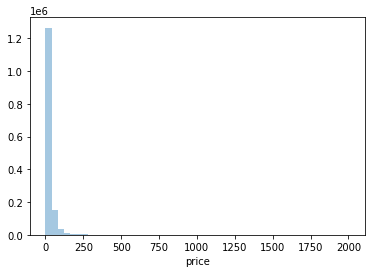

In [20]:
# Target 값인 price 칼럼의 데이터 분포도 확인.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

>price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡되어 분포되어 있음. -->로그값으로 변환.

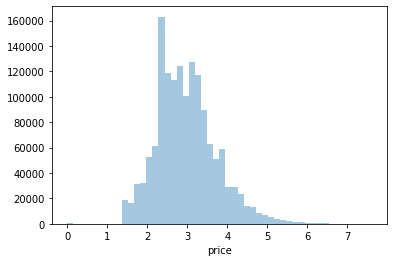

In [21]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

>비교적 정규분포에 가까운 데이터를 이루게 됨.

In [22]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [23]:
# shipping과 item_condition_id 값도 살피기.
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


>* Shipping 칼럼: 배송비 유무. 값이 비교적 균일함.
* Item_condition_id: 판매자가 제공하는 제품 상태.(무슨 의미인지는 기재되어 있지 않음)
* item_description 칼럼은 Null 값이 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet'이라 되어있음.

In [24]:
boolean_cond = mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

>* category_name은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음
* 'Men/Tops/T-shirts'는 대분류 'Men',중분류 'Tops',소분류'T-shirts'로 나눌 수 있음
* category_name은 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수 있지만,<br/>
여기서는 category_name의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습.

>* category_name 칼럼을 '/'를 기준으로 대, 중, 소분류를 효과적으로 분리해 내기 위해 별도의 split_cat() 함수를 생성하고 이를 DataFrame의 apply lambda 식에 적용.
* split_cat() 함수는 먼저 category_name이 Null이 아닌 경우에 split('/')를 이용해 대, 중, 소분류를 분리함.<br/>
파이썬은 문자열에 split(tokenizer 문자) 함수를 호출하면 tokenizer 문자에 따라 문자열을 분리해 리스트로 반환함.
* 만일 category_name이 Null일 경우에는 split() 함수가 Error를 발생하므로 이 Error를 except catch하여 대, 중, 소분류 모두 'Other Null'값을 부여함.

In [25]:
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성 후 대, 중, 소 값을 리스트로 반환.
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null','Other_Null','Other_Null']

# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성.
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x: split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류,소분류는 값의 유형이 많으므로 분류 개수만 추출.
print('대분류 유형:\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형:
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


>마지막으로 brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경.<br/>
fillna()를 적용한 뒤에 각 칼럼별로 Null 값이 없는지 다음과 같이 mercari_df.isnull().sum()을 호출해 확인하면 모든 칼럼에서 Null 건수가 0 임을 알 수 있음.

In [26]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야 함.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

**피처 인코딩과 피처 벡터화**

>* 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나  피처 벡터화로 변환할 칼럼 선별.
* Mercari Price Suggestion에서 예측 모델은 price 값, 즉 상품 가격을 예측해야 하므로 회귀 모델을 기반으로 함.
* 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이며, 특히 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩 적용.
* 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화를 적용.

In [27]:
# brand_name부터 검토.(상품의 브랜드명)
print('brand name의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수 : 4810
brand name sample 5건 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


* 대부분 명료한 문자열로 되어 있음 -->별도의 피처 벡터화 형태로 바꿀 필요 ㅇ벗이 인코딩 변환 적용.
* 원-핫 인코딩 변환.

In [28]:
# name(상품명)
print('name의 유형 건수 :', mercari_df['name'].nunique())
print('name sample 5건 : \n', mercari_df['name'][:10])

name의 유형 건수 : 1225273
name sample 5건 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


* 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 되어 있으므로 Count 기반으로 피처 벡터화 변환 적용.

>* category_name 칼럼은 이전에 전처리를 통해 대,중,소 분류 세 개의 칼럼인 cat_dae, cat_jung, cat_so 칼럼으로 분리됨 -->원-핫 인코딩 적용.
* shipping 칼럼은 배송비 무료 여부로서 0과 1 두가지 유형의 값. --> 원-핫 인코딩 적용
* item_condition_id는 상품 상태로서 1,2,3,4,5의 다섯 가ㅣㅈ 유형의 값 --> 원-핫 인코딩 적용

In [29]:
# item_description: 상품에 대한 간단 설명(가장 긴 텍스트 가지고 있음)
pd.set_option('max_colwidth',200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

* 평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환.

>이제 주요 칼럼을 인코딩 및 피처 벡터화 변환.
* 먼저 name과 item_description 칼럼: 피처 벡터화.<br/>
name의 경우 CountVectorizer로, item_description 칼럼은 TfidfVectorizer로 변환.

In [30]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_Description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


* CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태.
* 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩 될 cat_dae,cat_jung,cat_so,brand_name,shipping,item_condition_id도 모두 X_name,X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 함.

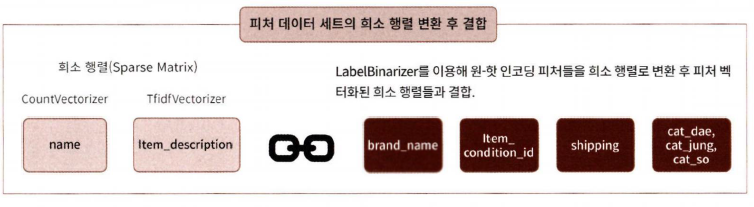

In [31]:
# 먼저 인코딩 대상 칼럼을 모두 LabelBinarizer로 원-핫 인코딩 변환.
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_Dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [32]:
# 생성된 인코딩 데이터 세트의 타입과 shape을 통해 제대로 변환되었는지 확인.
print(type(X_brand),type(X_item_cond_id),type(X_shipping))
print('X_brand shape : {0}, X_item_cond_id.shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape : {0}, X_cat_dae.shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape : {0}, X_cat_so.shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape : (1482535, 4810), X_item_cond_id.shape:(1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae.shape:(1482535, 11)
X_cat_jung shape : (1482535, 114), X_cat_so.shape:(1482535, 871)


>인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입.<br/>
이번에는 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합해보기.


In [33]:
from scipy.sparse import hstack
import gc
sparse_matrix_list = (X_name, X_descp, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합.
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 156759)


68

**릿지 회귀 모델 구축 및 평가**

* 모델을 평가하는 평가 로직 함수화. Rmsle 방식의 평가 지표 적용.<br/>
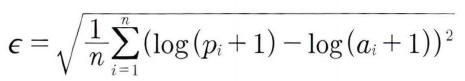

In [34]:
def rmsle(y,y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 그닏 rPtks
  return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred),2)))

def evaluate_org_price(y_test,preds):

  # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요.
  preds_exmpm = np.expm1(preds)
  y_test_exmpm = np.expm1(y_test)

  #rmsle로 RMSLE 값 추출
  rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
  return rmsle_result

In [35]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
  # scipy.spase 모듈의 hstack을 이용해 최소 행렬 결합
  X=hstack(matrix_list).tocsr()

  X_train,X_test,y_train,y_test=train_test_split(X,mercari_df['price'],test_size=0.2,random_state=156)

  # 모델 학습 및 예측
  model.fit(X_train,y_train)

  preds = model.predict(X_test)

  del X, X_train, X_test,y_train
  gc.collect()

  return preds, y_test

In [36]:
# Ridge를 이용해 Mercari Price의 회귀 예측 수행.
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:',evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,X_shipping,X_cat_dae,X_cat_jung,X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list = sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5023727038010556
Item Description을 포함한 rmsle 값: 0.47121951434336345


* Item Description을 포함했을 떄 rmsle 값 많이 감소함.(영향이 중요하다.)

**LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가**

In [ ]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

>Ridge보다 예측 성능 나아짐.

In [ ]:
# 예측 결괏값 서로 앙상블 해 최종 예측 결괏값 도출.
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:', evaluation_org_price(y_test,preds))